## 📦 **Import Libraries**

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.4 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

services = pd.read_csv(dir + 'services_preprocessed_re.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [ ]:
services.head()

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000
2,2,kalau dengar kata iklan pasti yang di pikiran ...,3.0,"['Advertising', 'Design Arts', 'Brochure', 'Gr...",150000
3,3,sulit intregasi mutasi bank ke sistem anda kam...,7.0,"['JavaScript', 'PHP', 'CodeIgniter', 'Yii', 'W...",500000
4,4,kami melayani pembuatan desain dengan harga mu...,3.0,"['CorelDRAW', 'Graphic Design', 'Logo Design',...",150000


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

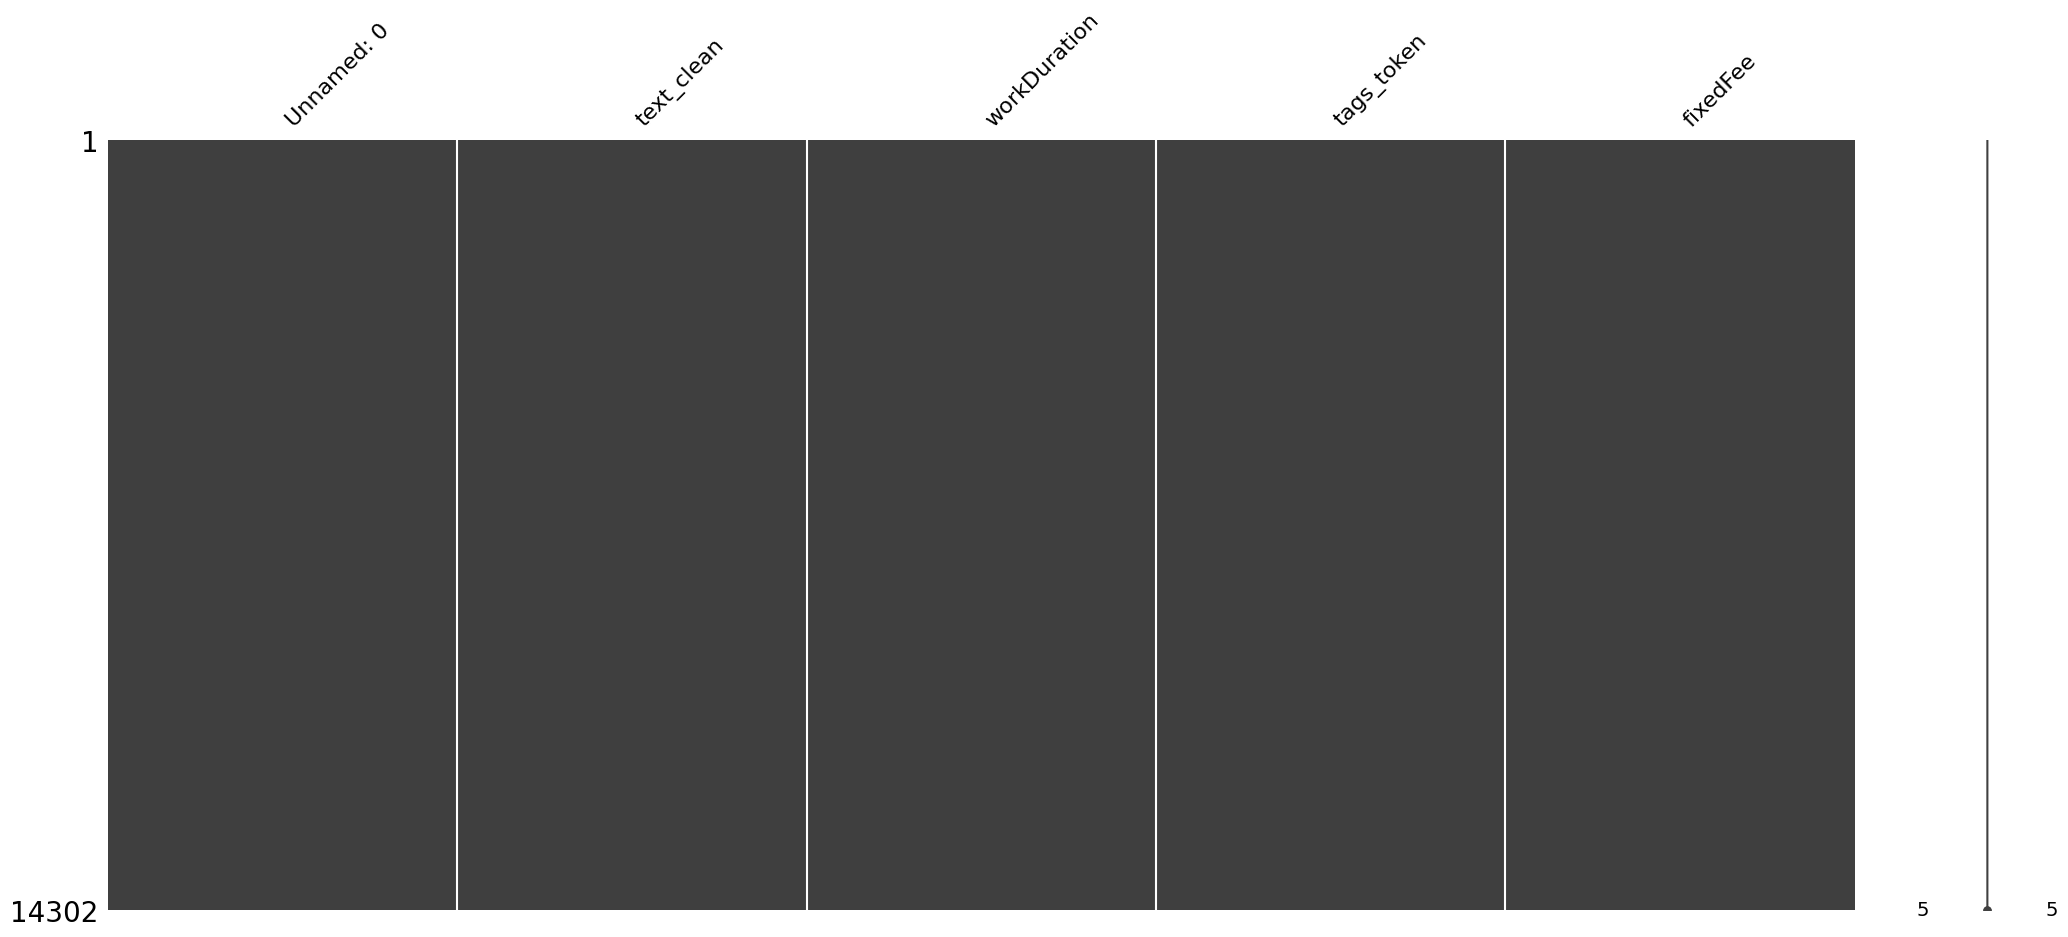

In [ ]:
msno.matrix(services)
plt.show()

In [ ]:
round(services.isna().mean().sort_values(ascending = False), 4)

Unnamed: 0      0.0
text_clean      0.0
workDuration    0.0
tags_token      0.0
fixedFee        0.0
dtype: float64

In [ ]:
df = services

In [ ]:
df

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000
2,2,kalau dengar kata iklan pasti yang di pikiran ...,3.0,"['Advertising', 'Design Arts', 'Brochure', 'Gr...",150000
3,3,sulit intregasi mutasi bank ke sistem anda kam...,7.0,"['JavaScript', 'PHP', 'CodeIgniter', 'Yii', 'W...",500000
4,4,kami melayani pembuatan desain dengan harga mu...,3.0,"['CorelDRAW', 'Graphic Design', 'Logo Design',...",150000
...,...,...,...,...,...
14297,14297,siap bantu anda memiliki website online shop c...,5.0,"['Website', 'Wordpress', 'Web Design', 'Websit...",8000000
14298,14298,dapatkan logo dan poster yang menarik dan prof...,7.0,"['CorelDRAW', 'Adobe PhotoShop', 'Adobe Illust...",150000
14299,14299,tahapan pengerjaan client melakukan konsultasi...,30.0,"['MySQL', 'C#', 'Desktop Programming', 'SQL Se...",2500000
14300,14300,halo projects cowok id saya menyediakan jasa t...,3.0,"['Translation', 'Writing']",50000


In [ ]:
df.rename(columns = {'tags_token':'service_tags'}, inplace = True)
df.rename(columns = {'text_clean':'text'}, inplace = True)
df.drop('Unnamed: 0', axis = 1, inplace = True)

##`project_tags`

In [ ]:
# Filtering the rare terms.
df_filtered = df.groupby("service_tags").filter(lambda x: len(x) > 1)
df_filtered['service_tags']

2        ['Advertising', 'Design Arts', 'Brochure', 'Gr...
5                     ['Search Engine Optimization (SEO)']
6                                              ['Youtube']
13                    ['Search Engine Optimization (SEO)']
16                                             ['Website']
                               ...                        
14291                    ['Advertising', 'Google Adwords']
14292                                          ['Android']
14293                                       ['Copywriter']
14297    ['Website', 'Wordpress', 'Web Design', 'Websit...
14300                           ['Translation', 'Writing']
Name: service_tags, Length: 6947, dtype: object

In [ ]:
import ast 

df_filtered['service_tags'] = [ast.literal_eval(i) for i in df_filtered['service_tags']]
df_filtered['service_tags'].values[:5]

array([list(['Advertising', 'Design Arts', 'Brochure', 'Graphic Design', 'Logo Design', 'Adobe PhotoShop', 'Adobe Illustrator', 'Multimedia', 'PIC', 'Instagram', 'Infogram']),
       list(['Search Engine Optimization (SEO)']), list(['Youtube']),
       list(['Search Engine Optimization (SEO)']), list(['Website'])],
      dtype=object)

In [ ]:
df_filtered['text'] = df_filtered['text'].astype(str)

## Base Model

In [ ]:
df_filtered.head()

,text,workDuration,service_tags,fixedFee
2,kalau dengar kata iklan pasti yang di pikiran ...,3.0,"[Advertising, Design Arts, Brochure, Graphic D...",150000
5,web 2 0 website is site where you can create a...,5.0,[Search Engine Optimization (SEO)],150000
6,promo subscriber channel youtube aktif rekomen...,3.0,[Youtube],70000
13,rank your website ini search engine with high ...,7.0,[Search Engine Optimization (SEO)],250000
16,bagi anda yang membutuhkan website tour dan tr...,3.0,[Website],4000000


In [ ]:
from sklearn.model_selection import train_test_split

test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["service_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 5557
Number of rows in validation set: 695
Number of rows in test set: 695


In [ ]:
test_df.to_csv(dir + "service_test_df.csv", index=True)

In [ ]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    5557.000000
mean       59.637394
std        30.450961
min         1.000000
25%        36.000000
50%        63.000000
75%        78.000000
max       330.000000
Name: text, dtype: float64

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
terms = tf.ragged.constant(train_df["service_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Adobe PhotoShop', 'Graphic Design', 'Adobe Illustrator', 'Writing', 'Website', 'CorelDRAW', 'Logo Design', 'Website Building', 'Data Entry', 'Wordpress', 'Social Media Marketing (SMM)', 'Web Design', 'Translation', 'Search Engine Optimization (SEO)', 'Website Templates', 'Design Arts', 'Web Programming', 'Internet Marketing', 'PHP', 'Content Writer', 'Microsoft Word', 'Copywriter', 'Video Editing', 'Wordpress Templates', 'Video Production', 'Microsoft Excel', 'Photography', 'Instagram', 'Accounting', 'Advertising', 'Blog', 'MySQL', 'Illustration', 'Android', 'English', 'Tax Consultation', 'Vector Graphics', 'Retyping', 'Marketing Strategy', 'Blogspot', 'Sales and Marketing', 'Adobe Premiere', 'Youtube', 'CodeIgniter', '3D Modelling', 'Microsoft PowerPoint', 'HTML', '3D Architecture', 'Business Document Translation', 'Adobe After Effects', 'Adobe Indesign', 'Microsoft Office', 'Data Analysis', '3D Rendering', 'Web Research', 'Business Service', 'Laravel Framework

In [ ]:
sample_label = train_df["service_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['3D Architecture', '3D Rendering', 'SketchUp']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [ ]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["service_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'halo gamers nama saya farhan luthfan farisan saya seorang video editor profesional yang telah berpengalaman 2 tahun saya menawarkan anda service editing video meme bisa untuk game mobile ataupun pc plus dengan thumbnail untuk youtube dan igtv yang akan anda dapatkan dari service saya meme video gambar yang sering dipakai youtuber streamer sound effect lucu backsound zoom ini zoom out video transition thumbail full hd video mp4 1920 1080 60 fps video jika mentahan videonya 60 fps juga revisi 5 kali tidak melenceng dari konsep awal yang telah dibicarakan tata cara client dan editor membicarakan tentang konsep video editor mengerjakan video sesuai keinginan client video dikirim ke client revisi jika ada selesai paket max 5 menit video pengerjaan 1 hari rp'
Label(s): ['Adobe PhotoShop' 'Video Editing' 'Adobe Premiere']
 
Text: b'pajak merupakan kewajiban yang harus di tunaikan jika tidak maka akan ada sanksi administratif maupun financial dari djp terkadang kita tidak mempunyai wak

In [ ]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

17250


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
44/44 [==============================] - 6s 15ms/step - loss: 0.1315 - binary_accuracy: 0.9640 - val_loss: 0.0509 - val_binary_accuracy: 0.9916
Epoch 2/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0312 - binary_accuracy: 0.9930 - val_loss: 0.0342 - val_binary_accuracy: 0.9924
Epoch 3/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0135 - binary_accuracy: 0.9962 - val_loss: 0.0304 - val_binary_accuracy: 0.9926
Epoch 4/20
44/44 [==============================] - 1s 11ms/step - loss: 0.0069 - binary_accuracy: 0.9981 - val_loss: 0.0304 - val_binary_accuracy: 0.9927
Epoch 5/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0043 - binary_accuracy: 0.9990 - val_loss: 0.0312 - val_binary_accuracy: 0.9928
Epoch 6/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0029 - binary_accuracy: 0.9994 - val_loss: 0.0347 - val_binary_accuracy: 0.9927
Epoch 7/20
44/44 [==============================] - 1s 12ms/step - los

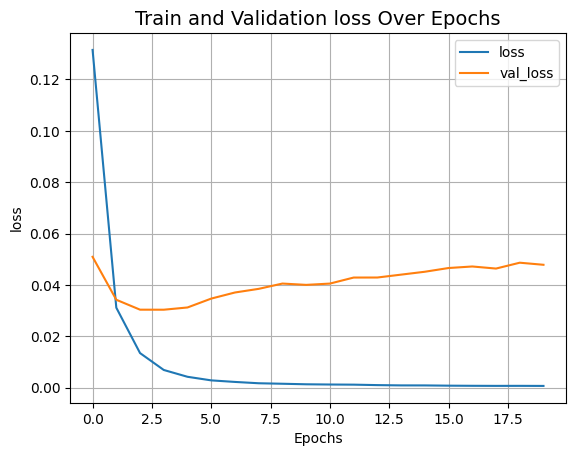

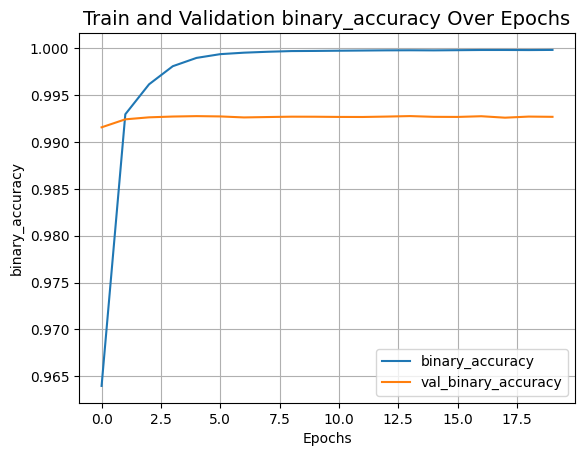

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [ ]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

6/6 [==============================] - 0s 9ms/step - loss: 0.0494 - binary_accuracy: 0.9928
Categorical accuracy on the test set: 99.28%.


## Saving Model

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/services/'

In [ ]:
!mkdir -p saved_model
shallow_mlp_model.save(path + 'service_tags_model/my_model')

## Load Model

In [ ]:
services_tags_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ml-stuff/model/services/service_tags_model/my_model')

## Prediction

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, services_tags_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 7ms/step
Text: b'hai sobat peneliti apakah kamu salah satu peneliti yang mau cepat lulus dan punya banyak tapi tapi dataku trouble bingung mau diapakan jadiii apakah kamu yakin metode mu sudah benar yakin intrepretasinya sudah sesuai santaiiii gurls and guys fastrack idea solusinya dengan team yang terdiri dari master statistika dan sudah berpengalaman lebih dari 5 tahun kami siap membantu kamu menyelesaikan segala masalah datamu kamu bisa curhat tentang problematika datamu lho'
Label(s): ['Data Analysis' 'Consultancy' 'Business Consultation'
 'Statistical Analysis' 'Business Analysis' 'Analysis'
 'Quantitative Analysis' 'Technical Analysis' 'SPSS']
Predicted Label(s): (Technical Analysis, Analysis, Statistical Analysis, SPSS, Quantitative Analysis)
 
Text: b'pusing skripsi ta masih belum rapi juga baca menonton tutorial tetapi masih salah salah juga tidak punya banyak waktu karena sibuk atau bentrok dengan pekerjaan lain saya siap membantu and